# How to write a training loop in Chainer

In this tutorial section, we will learn how to train a deep neural network to classify images of hand-written digits in the popular MNIST dataset. This dataset contains 50,000 training examples and 10,000 test examples. Each example is a set of a 28 x 28 greyscale image and a corresponding class label. Since the digits from 0 to 9 are used, there are 10 classes for the labels.

Chainer provides a feature called [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) that can simplify the training procedure of your model. However, it is also good to know how the training works in Chainer before starting to use the useful [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) class that hides the actual processes. Writing your own training loop can be useful for learning how [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) works or for implementing features not included in the standard trainer.

The complete training procedure consists of the following steps:

1. Prepare a dataset
2. Create a dataset iterator
3. Define a network
4. Select an optimization algorithm
5. Write a training loop
    1. Retrieve a set of examples (mini-batch) from the training dataset.
    2. Feed the mini-batch to your network.
    3. Run a forward pass of the network and compute the loss.
    4. Just call the [backward()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable.backward) method from the loss [Variable](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable) to compute the gradients for all trainable parameters.
    5. Run the optimizer to update those parameters.
6. Save the trained model
7. Perform classification by the saved model and check the network performance on validation/test sets.

First, let's import the necessary packages for using Chainer.

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import matplotlib.pyplot as plt
from chainer.datasets import mnist

# 1. Prepare a dataset

Chainer contains some built-in functions to use some popular datasets like MNIST, CIFAR10/100, etc. Those can automatically download the data from servers and provide dataset objects which are easy to use.

The code below shows how to retrieve the MNIST dataset from the server and save an image from its training split to make sure the images are correctly obtained.

In [2]:
# Download the MNIST data if you haven't downloaded it yet
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# Display an example from the MNIST dataset.
# `x` contains the inpu t image array and `t` contains that target class
# label as an integer.
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.savefig('5.png')
print('label:', t)

label: 5


The saved image `5.png` will look like:

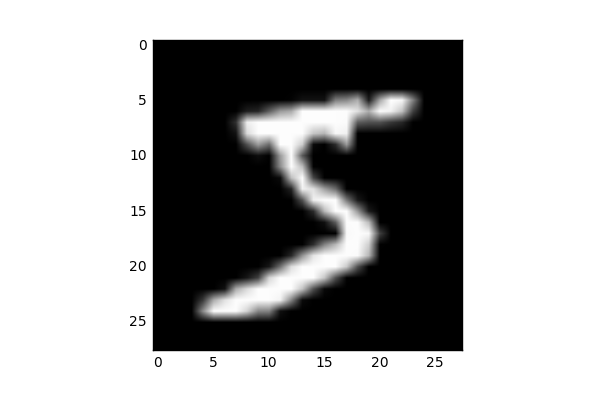

In [3]:
from IPython.display import Image
Image('5.png')

# 2. Create a dataset iterator

Although this is an optional step, we’d like to introduce the [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) class that retrieves a set of data and labels from the given dataset to easily make a mini-batch. There are some subclasses that can perform the same thing in different ways, e.g., using multi-processing to parallelize the data loading part, etc.

Here, we use [SerialIterator](https://docs.chainer.org/en/latest/reference/generated/chainer.iterators.SerialIterator.html#chainer.iterators.SerialIterator), which is also a subclass of [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) in the example code below. The [SerialIterator](https://docs.chainer.org/en/latest/reference/generated/chainer.iterators.SerialIterator.html#chainer.iterators.SerialIterator) can provide mini-batches with or without shuffling the order of data in the given dataset.

All [Iterators](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) produce a new mini-batch by calling its [next()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator.next) method. All [Iterators](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) also have properties to know how many times we have taken all the data from the given dataset (epoch) and whether the next mini-batch will be the start of a new epoch (`is_new_epoch`), and so on.

The code below shows how to create a [SerialIterator](https://docs.chainer.org/en/latest/reference/generated/chainer.iterators.SerialIterator.html#chainer.iterators.SerialIterator) object from a dataset object.

In [4]:
from chainer import iterators

# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

**Note**

`iterator`s can take a built-in Python list as a given dataset. It means that the example code below is able to work,

```
train = [(x1, t1), (x2, t2), ...]  # A list of tuples
train_iter = iterators.SerialIterator(train, batchsize)
```

where `x1, x2, ...` denote the input data and `t1, t2, ...` denote the corresponding labels.

## Details of [SerialIterator](https://docs.chainer.org/en/latest/reference/generated/chainer.iterators.SerialIterator.html#chainer.iterators.SerialIterator)

- [SerialIterator](https://docs.chainer.org/en/latest/reference/generated/chainer.iterators.SerialIterator.html#chainer.iterators.SerialIterator) is a built-in subclass of [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) that can retrieve a mini-batch from a given dataset in either sequential or shuffled order.
- The [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator)‘s constructor takes two arguments: a dataset object and a mini-batch size.
- If you want to use the same dataset repeatedly during the training process, set the `repeat` argument to `True` (default). Otherwise, the dataset will be used only one time. The latter case is actually for the evaluation.
- If you want to shuffle the training dataset every epoch, set the `shuffle` argument to `True`. Otherwise, the order of each data retrieved from the dataset will be always the same at each epoch.

In the example code shown above, we set `batchsize = 128` in both `train_iter` and `test_iter`. So, these iterators will provide 128 images and corresponding labels at a time.

# 3. Define a network

Now let’s define a neural network that we will train to classify the MNIST images. For simplicity, we use a three-layer perceptron here. We set each hidden layer to have 100 units and set the output layer to have 10 units, which is corresponding to the number of class labels of the MNIST.

## Create your network as a subclass of Chain

You can create your network by writing a new subclass of [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain). The main steps are twofold:

1. Register the network components which have trainable parameters to the subclass. Each of them must be instantiated and assigned to a property in the scope specified by [init_scope()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain.init_scope)
2. Define a `__call__()` method that represents the actual **forward computation** of your network. This method takes one or more [Variable](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable), `numpy.array`, or `cupy.array` as its inputs and calculates the forward pass using them.

In [5]:
class MyNetwork(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MyNetwork, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return self.l3(h)

model = MyNetwork()

[Link](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Link.html#chainer.Link), [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain), [ChainList](https://docs.chainer.org/en/latest/reference/core/generated/chainer.ChainList.html#chainer.ChainList), and those subclass objects which contain trainable parameters should be registered to the model by assigning it as a property inside the [init_scope()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain.init_scope). For example, a [Function](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Function.html#chainer.Function) does not contain any trainable parameters, so there is no need to keep the object as a property of your network. When you want to use [relu()](https://docs.chainer.org/en/latest/reference/generated/chainer.functions.relu.html#chainer.functions.relu) in your network, using it as a function in `__call__()` works correctly.

In Chainer, the Python code that implements the forward computation itself represents the network. In other words, we can conceptually think of the computation graph for our network being constructed dynamically as this forward computation code executes. This allows Chainer to describe networks in which different computations can be performed in each iteration, such as branched networks, intuitively and with a high degree of flexibility. This is the key feature of Chainer that we call **Define-by-Run**.

# 4. Select an optimization algorithm

Chainer provides a wide variety of optimization algorithms that can be used to optimize the network parameters during training. They are located in `optimizers` module.

Here, we are going to use the stochastic gradient descent (SGD) method with momentum, which is implemented by [MomentumSGD](https://docs.chainer.org/en/latest/reference/generated/chainer.optimizers.MomentumSGD.html#chainer.optimizers.MomentumSGD). To use the optimizer, we give the network object (typically it’s a [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) or [ChainList](https://docs.chainer.org/en/latest/reference/core/generated/chainer.ChainList.html#chainer.ChainList)) to the [setup()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer.setup) method of the optimizer object to register it. In this way, the [Optimizer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer) can automatically find the model parameters and update them during training.

You can easily try out other optimizers as well. Please test and observe the results of various optimizers. For example, you could try to change [MomentumSGD](https://docs.chainer.org/en/latest/reference/generated/chainer.optimizers.MomentumSGD.html#chainer.optimizers.MomentumSGD) to [Adam](https://docs.chainer.org/en/latest/reference/generated/chainer.optimizers.Adam.html#chainer.optimizers.Adam), [RMSprop](https://docs.chainer.org/en/latest/reference/generated/chainer.optimizers.RMSprop.html#chainer.optimizers.RMSprop), etc.

In [6]:
# Choose an optimizer algorithm
optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

**Note**

In the above example, we set `lr` to 0.01 in the constructor. This value is known as the “learning rate”, one of the most important hyperparameters that need to be adjusted in order to obtain the best performance. The various optimizers may each have different hyperparameters and so be sure to check the documentation for the details.

# 5. Write a training loop

We now show how to write the training loop. Since we are working on a digit classification problem, we will use [softmax_cross_entropy()](https://docs.chainer.org/en/latest/reference/generated/chainer.functions.softmax_cross_entropy.html#chainer.functions.softmax_cross_entropy) as the loss function for the optimizer to minimize. For other types of problems, such as regression models, other loss functions might be more appropriate. See the [Chainer documentation for detailed information on the various loss functions](http://docs.chainer.org/en/stable/reference/functions.html#loss-functions) for more details.

Our training loop will be structured as follows.

1. We will first get a mini-batch of examples from the training dataset.
2. We will then feed the batch into our network by calling it (a [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) object) like a function. This will execute the forward-pass code that are written in the `__call__()` method.
3. This will return the network output that represents class label predictions. We supply it to the loss function along with the true (that is, target) values. The loss function will output the loss as a [Variable](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable) object.
4. We then clear any previous gradients in the network and perform the backward pass by calling the [backward()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable.backward) method on the loss variable which computes the parameter gradients. We need to clear the gradients first because the [backward()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable.backward) method accumulates gradients instead of overwriting the previous values.
5. Since the optimizer already has a reference to the network, it has access to the parameters and the computed gradients so that we can now call the [update()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer.update) method of the optimizer which will update the model parameters.

In addition to the above steps, you might want to check the performance of the network with a validation dataset. This allows you to observe how well it is generalized to new data so far, namely, you can check whether it is overfitting to the training data. The code below checks the performance on the test set at the end of each epoch. The code has the same structure as the training code except that no backpropagation is performed and we also compute the accuracy on the test data using the [accuracy()](https://docs.chainer.org/en/latest/reference/generated/chainer.functions.accuracy.html#chainer.functions.accuracy) function.

The training loop code is as follows:

In [7]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10
gpu_id = 0  # If you want to use GPU, set 0 (GPU ID you want to use)

if gpu_id >= 0:
    model.to_gpu(gpu_id)

while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable paremters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, gpu_id)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.2116 val_loss:0.2687 val_accuracy:0.9220
epoch:02 train_loss:0.1313 val_loss:0.2002 val_accuracy:0.9409
epoch:03 train_loss:0.1957 val_loss:0.1500 val_accuracy:0.9558
epoch:04 train_loss:0.1097 val_loss:0.1296 val_accuracy:0.9603
epoch:05 train_loss:0.0953 val_loss:0.1185 val_accuracy:0.9639
epoch:06 train_loss:0.0844 val_loss:0.1012 val_accuracy:0.9687
epoch:07 train_loss:0.1023 val_loss:0.0974 val_accuracy:0.9694
epoch:08 train_loss:0.0638 val_loss:0.0959 val_accuracy:0.9709
epoch:09 train_loss:0.0359 val_loss:0.0907 val_accuracy:0.9716
epoch:10 train_loss:0.1176 val_loss:0.0876 val_accuracy:0.9725


# 6. Save the trained model

Chainer provides two types of [serializers](https://docs.chainer.org/en/latest/reference/serializers.html#module-chainer.serializers) that can be used to save and restore model state. One supports the HDF5 format and the other supports the NumPy NPZ format. For this example, we are going to use the NPZ format to save our model since it is easy to use with NumPy and doesn’t need to install any additional dependencies or libraries.

In [8]:
serializers.save_npz('my_mnist.model', model)

# 7. Perform classification by the saved model

Let’s use the saved model to classify a new image. In order to load the trained model parameters, we need to perform the following two steps:

1. Instantiate the same network as what you trained.
2. Overwrite all parameters in the model instance with the saved weights using the [load_npz()](https://docs.chainer.org/en/latest/reference/generated/chainer.serializers.load_npz.html#chainer.serializers.load_npz) function.

Once the model is restored, it can be used to predict image labels on new input data.

In [9]:
from chainer import serializers

# Create an instance of the network you trained
model = MyNetwork()

# Load the saved paremeters into the instance
serializers.load_npz('my_mnist.model', model)

# Get a test image and label
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.savefig('7.png')
print('label:', t)

label: 7


The saved test image looks like:

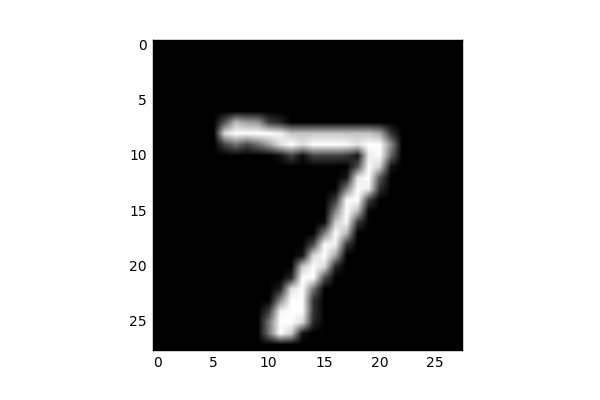

In [10]:
Image('7.png')

In [11]:
# Change the shape of the minibatch.
# In this example, the size of minibatch is 1.
# Inference using any mini-batch size can be performed.

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# forward calculation of the model by sending X
y = model(x)

# The result is given as Variable, then we can take a look at the contents by the attribute, .data.
y = y.data

# Look up the most probable digit number using argmax
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7


**The prediction result looks correct. Yay!**